In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix



# clasification per OTU

In [2]:

matrix_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-otus-99-filtered-matrix.npz"
samples_txt = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/matrix_samples.txt"
taxonomy_names_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/matrix_taxa_with_taxonomy.txt"
df_taxonomy = pd.read_csv(taxonomy_names_path, sep="\t", header=None, names=["OTU_ID", "taxonomy"])

# Load the matrix
X = sp.load_npz(matrix_path)  # shape (N_samples, N_features)

# Load the sample IDs in the same row order
with open(samples_txt, "r") as f:
    sample_ids = [line.strip() for line in f]

print("Matrix shape:", X.shape)
print("Number of rows (samples):", len(sample_ids))
print("Number of columns (OTUs):", len(df_taxonomy))


Matrix shape: (1836255, 148615)
Number of rows (samples): 1836255
Number of columns (OTUs): 148615


In [3]:
metadata_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/sample_metadata_limited_100_percent.csv"
df = pd.read_csv(metadata_path)

# Create dictionaries for quick lookup: { sample_id_str -> category_str } and { sample_id_str -> scientific_name }
label_map = dict(zip(df["Sample ID"], df["Category"]))
scientific_name_map = dict(zip(df["Sample ID"], df["Scientific Name"]))

print("Metadata rows:", len(df))

# Extract the labels and scientific names for the samples in the same order as the matrix
y = []
y_scientific_name = []
unmatched_count = 0

for sid in sample_ids:
    sid = sid.split('.')[1]
    if sid in label_map:
        y.append(label_map[sid])
        y_scientific_name.append(scientific_name_map.get(sid, "Unknown"))  # Use "Unknown" if not found
    else:
        y.append(None)
        y_scientific_name.append(None)
        unmatched_count += 1

print(f"Created y with length = {len(y)}")
print(f"Created y_scientific_name with length = {len(y_scientific_name)}")
print(f"Unmatched samples (no label found) = {unmatched_count}")


# Delete the samples that are missing in the CSV (i.e. have None as label)
X_filtered_rows = []
y_filtered = []
y_scientific_name_filtered = []
filtered_sample_ids = []

for i, label in enumerate(y):
    if label is not None:
        X_filtered_rows.append(i)
        y_filtered.append(label)
        y_scientific_name_filtered.append(y_scientific_name[i])  # Keep scientific name in sync
        filtered_sample_ids.append(sample_ids[i])

# Now build a smaller matrix with only those rows
X_filtered = X[X_filtered_rows, :]

# Convert y_filtered to numpy array
y_filtered = np.array(y_filtered)
y_scientific_name_filtered = np.array(y_scientific_name_filtered)

# Encode y labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_filtered)

Metadata rows: 2187608
Created y with length = 1836255
Created y_scientific_name with length = 1836255
Unmatched samples (no label found) = 96060


In [4]:
# Split into train/test while keeping track of indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X_filtered, y_encoded, np.arange(len(y_encoded)),  # Add indices
    test_size=0.2, random_state=123
)

# Train classifier
clf = LogisticRegression(solver="saga", max_iter=1000, random_state=123)
clf.fit(X_train, y_train)

# Evaluate model
acc = clf.score(X_test, y_test)
print("Test accuracy:", acc)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test accuracy: 0.8936383566209534
Accuracy: 0.8936383566209534

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.86    136969
           1       0.91      0.92      0.91    211070

    accuracy                           0.89    348039
   macro avg       0.89      0.89      0.89    348039
weighted avg       0.89      0.89      0.89    348039



In [5]:
# Identify misclassified indices
misclassified_indices = [i for i in range(len(y_test)) if y_test[i] != y_pred[i]]

# Map back to original sample indices
misclassified_sample_ids = [filtered_sample_ids[test_indices[i]] for i in misclassified_indices]
misclassified_true_classes = [y_test[i] for i in misclassified_indices]
misclassified_predicted_classes = [y_pred[i] for i in misclassified_indices]
misclassified_scientific_names = [y_scientific_name_filtered[test_indices[i]] for i in misclassified_indices]

# Decode true and predicted class names using label encoder
true_class_names = label_encoder.inverse_transform(misclassified_true_classes)
predicted_class_names = label_encoder.inverse_transform(misclassified_predicted_classes)

# Create a DataFrame for easy visualization
df_misclassified = pd.DataFrame({
    "Sample ID": misclassified_sample_ids,
    "True Class": true_class_names,
    "Predicted Class": predicted_class_names,
    "Scientific Name": misclassified_scientific_names
})

# Show the first 10 misclassified cases
print(f" {len(df_misclassified)} Misclassified Samples:")
display(df_misclassified.head(20))

 37018 Misclassified Samples:


,Sample ID,True Class,Predicted Class,Scientific Name
0,SRR13178782.SRS7819032,Human,Non-Human,gut metagenome
1,SRR10857189.SRS5966702,Non-Human,Human,food fermentation metagenome
2,SRR13249865.SRS7879713,Human,Non-Human,gut metagenome
3,SRR8882784.SRS4611464,Non-Human,Human,metagenome
4,ERR1712717.ERS1381797,Non-Human,Human,uncultured bacterium
5,SRR6309372.SRS2702454,Human,Non-Human,skin metagenome
6,SRR8365765.SRS4183249,Non-Human,Human,mouse gut metagenome
7,ERR2816432.ERS2654643,Human,Non-Human,coral metagenome
8,SRR8942230.SRS4660754,Human,Non-Human,human metagenome
9,SRR9036476.SRS4742737,Non-Human,Human,metagenome


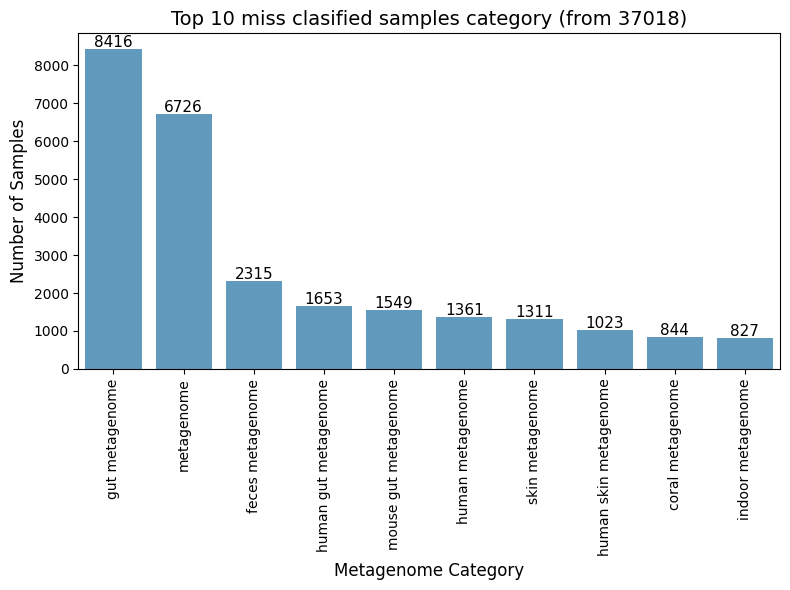

In [6]:
# Count the occurrences of each category
category_counts = df_misclassified["Scientific Name"].value_counts().head(10)

# Plot the histogram
plt.figure(figsize=(8, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, color=sns.color_palette("Blues_r")[2])
plt.xticks(rotation=90) 
# Labels and title
plt.xlabel("Metagenome Category", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.title(f"Top 10 miss clasified samples category (from {len(df_misclassified)})", fontsize=14)

# Show values on top of bars
for i, count in enumerate(category_counts.values):
    plt.text(i, count + 50, str(count), ha="center", fontsize=11 )
    
plt.tight_layout()
# Show the plot
plt.show()

In [7]:
X_test.shape

(348039, 148615)

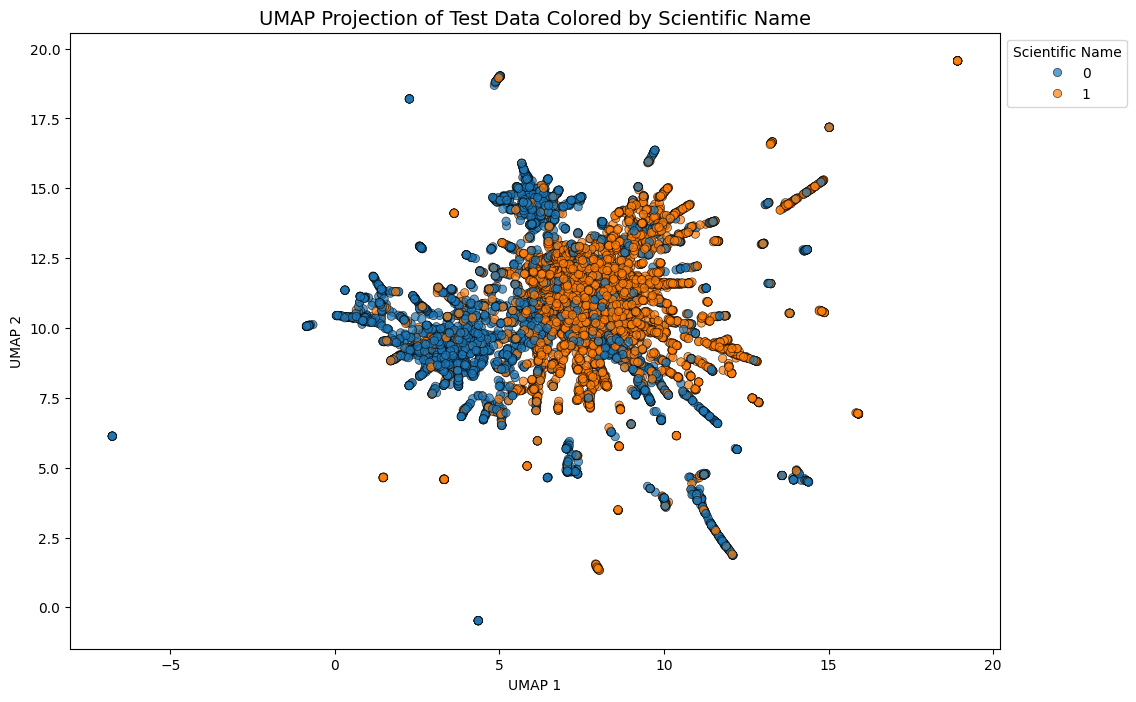

In [ ]:
import umap

# Reduce the dimensionality of X_test to 2D using UMAP
umap_reducer = umap.UMAP(n_components=2, n_jobs=20)
X_test_umap = umap_reducer.fit_transform(X_test[0:10000,:])
y_test_cut = y_test[0:10000]
# Create a DataFrame with UMAP results

df_umap = pd.DataFrame({
    "UMAP 1": X_test_umap[:, 0],
    "UMAP 2": X_test_umap[:, 1],
    "Scientific Name":  [y_test[i] for i in range(len(y_test_cut))]
    #[y_scientific_name_filtered[test_indices[i]] for i in range(len(y_test_cut))]
})

# Plot UMAP scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_umap, 
    x="UMAP 1", 
    y="UMAP 2", 
    hue="Scientific Name",  # Color by scientific name
    palette="tab10",  # Change to "tab20", "viridis", etc. for more colors
    alpha=0.7,  # Adjust transparency
    edgecolor="black",
    linewidth=0.5
)

plt.title("UMAP Projection of Test Data Colored by Scientific Name", fontsize=14)
plt.legend(loc="best", bbox_to_anchor=(1, 1), title="Scientific Name")
plt.show()

In [44]:
df_umap["Classification"]

0         Correct
1         Correct
2       Incorrect
3         Correct
4         Correct
          ...    
9995      Correct
9996      Correct
9997      Correct
9998      Correct
9999      Correct
Name: Classification, Length: 10000, dtype: object

In [31]:
# Reduce dimensionality using UMAP
umap_reducer = umap.UMAP(n_components=2, n_jobs=30)
X_test_umap = umap_reducer.fit_transform(X_test[:10000, :])
y_test_cut = y_test[:10000]

# Identify misclassified samples
misclassified_set = set(misclassified_indices)

# Map numeric labels to actual names
y_test_names = label_encoder.inverse_transform(y_test_cut)

# Create a DataFrame with UMAP results
df_umap = pd.DataFrame({
    "UMAP 1": X_test_umap[:, 0],
    "UMAP 2": X_test_umap[:, 1],
    "Labels": y_test_names,  # Use decoded class names
    "Classification": ["Incorrect" if i in misclassified_set else "Correct" for i in range(len(y_test_cut))]
})

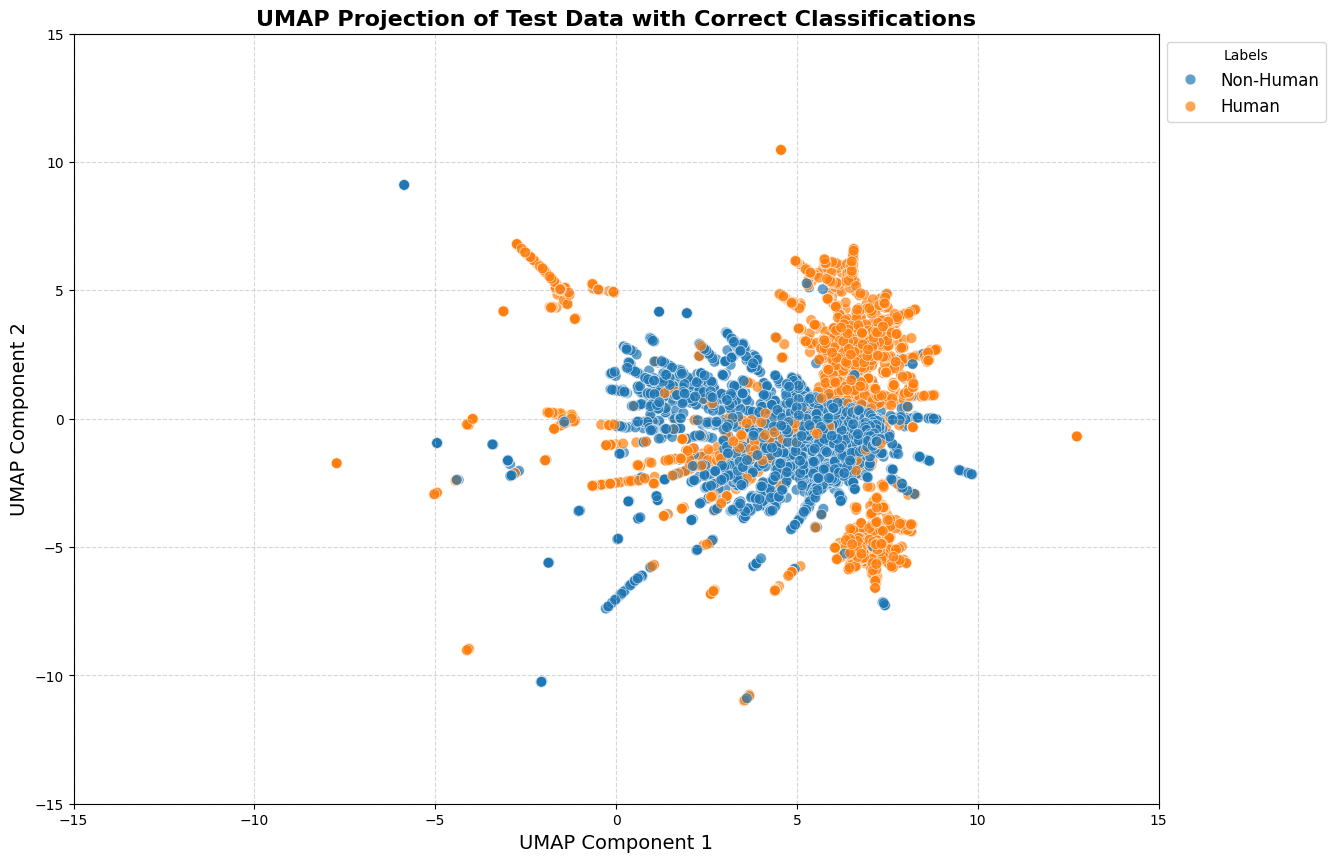

In [51]:
# Define a fixed color palette based on unique labels
unique_labels = df_umap["Labels"].unique()
fixed_palette = dict(zip(unique_labels, sns.color_palette("tab10", len(unique_labels))))

# Create figure
plt.figure(figsize=(14, 10))

# Plot Correctly Classified Points (Larger Dots)
correct_plot = sns.scatterplot(
    data=df_umap[df_umap["Classification"] == "Correct"], 
    x="UMAP 1", 
    y="UMAP 2", 
    hue="Labels",  
    palette=fixed_palette,  # Use the fixed palette
    alpha=0.7,  
    linewidth=0.5,
    marker="o",  # Circle for correct
    s=60  # Increase size of correct classifications
)

# Plot Incorrectly Classified Points (Red Crosses, Larger & Thicker)
# incorrect_plot = sns.scatterplot(
#     data=df_umap[df_umap["Classification"] == "Incorrect"], 
#     x="UMAP 1", 
#     y="UMAP 2", 
#     hue="Labels",  
#     palette=fixed_palette,  # Ensure same colors as the correct ones
#     alpha=1.0,  
#     linewidth=1.5,
#     marker="X",  # X for misclassified
#     s=80  # Slightly larger for incorrect classifications
# )

# Set the X-axis range manually
plt.xlim(-15, 15)  # Adjust according to your needs
plt.ylim(-15, 15)  # Adjust according to your needs

# Title and formatting
plt.title("UMAP Projection of Test Data with Correct Classifications", fontsize=16, fontweight="bold")
plt.xlabel("UMAP Component 1", fontsize=14)
plt.ylabel("UMAP Component 2", fontsize=14)

# Fix the legend order manually
handles, labels = plt.gca().get_legend_handles_labels()
legend_order = ["Non-Human", "Human"]  # Desired order
ordered_handles = [handles[labels.index(lbl)] for lbl in legend_order if lbl in labels]
plt.legend(ordered_handles, legend_order, loc="upper left", bbox_to_anchor=(1, 1), title="Labels", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)

# Show the improved visualization
plt.show()

# clasification using Taxonomi

In [52]:

matrix_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-otus-99-filtered-matrix.npz"
samples_txt = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/matrix_samples.txt"
taxonomy_names_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/matrix_taxa_with_taxonomy.txt"
df_taxonomy = pd.read_csv(taxonomy_names_path, sep="\t", header=None, names=["OTU_ID", "taxonomy"])

# Load the matrix
X = sp.load_npz(matrix_path)  # shape (N_samples, N_features)

# Load the sample IDs in the same row order
with open(samples_txt, "r") as f:
    sample_ids = [line.strip() for line in f]

print("Matrix shape:", X.shape)
print("Number of rows (samples):", len(sample_ids))
print("Number of columns (OTUs):", len(df_taxonomy))


Matrix shape: (1836255, 148615)
Number of rows (samples): 1836255
Number of columns (OTUs): 148615


In [53]:

# Step 1: Create Taxonomy Mapping
taxonomy_list = df_taxonomy["taxonomy"].unique()  # Unique taxonomies
taxonomy_index = {tax: i for i, tax in enumerate(taxonomy_list)}  # Map taxonomy to index
otu_index = {otu: i for i, otu in enumerate(df_taxonomy["OTU_ID"])}  # OTU to column index in X

# Step 2: Build Sparse Mapping Matrix (OTU → Taxonomy)
num_otus = len(df_taxonomy)
num_taxonomies = len(taxonomy_list)

# Sparse matrix shape (num_otus, num_taxonomies)
otu_to_taxonomy_matrix = sp.lil_matrix((num_otus, num_taxonomies))

for otu, tax in zip(df_taxonomy["OTU_ID"], df_taxonomy["taxonomy"]):
    otu_idx = otu_index[otu]
    tax_idx = taxonomy_index[tax]
    otu_to_taxonomy_matrix[otu_idx, tax_idx] = 1  # Assign OTU to corresponding taxonomy

otu_to_taxonomy_matrix = otu_to_taxonomy_matrix.tocsr()  # Convert to CSR for fast matrix multiplication

# Step 3: Aggregate OTU abundances by multiplying matrices
X_taxonomy = X @ otu_to_taxonomy_matrix  # (samples x OTUs) * (OTUs x Taxonomies) = (samples x Taxonomies)

# Step 4: Save New Matrix
taxonomy_matrix_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-taxonomy-matrix.npz"
sp.save_npz(taxonomy_matrix_path, X_taxonomy)

taxonomy_mapping_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/taxonomy_mapping.csv"
df_taxonomy_mapping = pd.DataFrame({"taxonomy": taxonomy_list})
df_taxonomy_mapping.to_csv(taxonomy_mapping_path, index=False)

print(f"✅ Optimized! Transformed OTU matrix to Taxonomy matrix with shape {X_taxonomy.shape}")
print(f"✅ Saved taxonomy matrix to: {taxonomy_matrix_path}")
print(f"✅ Saved taxonomy mapping to: {taxonomy_mapping_path}")

✅ Optimized! Transformed OTU matrix to Taxonomy matrix with shape (1836255, 8520)
✅ Saved taxonomy matrix to: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-taxonomy-matrix.npz
✅ Saved taxonomy mapping to: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/taxonomy_mapping.csv


In [54]:
# Select the first sample (index 0)
sample_index = 0

# Get non-zero OTUs for the first sample
nonzero_otu_indices = X[sample_index].nonzero()[1]  # Get OTU indices
nonzero_otu_values = X[sample_index, nonzero_otu_indices].toarray().flatten()  # Convert to array

# Get non-zero taxonomies for the first sample
nonzero_tax_indices = X_taxonomy[sample_index].nonzero()[1]  # Get taxonomy indices
nonzero_tax_values = X_taxonomy[sample_index, nonzero_tax_indices].toarray().flatten()  # Convert to array

# Retrieve OTU IDs and Taxonomy Names
otus = [df_taxonomy.iloc[i]["taxonomy"] for i in nonzero_otu_indices]
taxonomies = [taxonomy_list[i] for i in nonzero_tax_indices]  # taxonomy_list should contain unique taxonomies

# Display results
print("\n🔹 Non-Zero OTUs in Sample 1:")
for otu, value in zip(otus, nonzero_otu_values):
    print(f"  - {otu}: {value}")

print("\n🔹 Non-Zero Taxonomies in Sample 1:")
for tax, value in zip(taxonomies, nonzero_tax_values):
    print(f"  - {tax}: {value}")


🔹 Non-Zero OTUs in Sample 1:
  - d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium_A;s__Fusobacterium_A: 0.00641025641025641
  - d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae: 0.01282051282051282
  - d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae: 0.009615384615384616
  - d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae;g__Massiliomicrobiota;s__Massiliomicrobiota: 0.01282051282051282
  - d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides_A;s__Bacteroides_A: 0.01282051282051282
  - d__Bacteria;p__Firmicutes;c__Bacilli;o__Haloplasmatales;f__Turicibacteraceae;g__Turicibacter;s__Turicibacter: 0.27564102564102566
  - d__Bacteria;p__Firmicutes;c__Bacilli;o__Haloplasmatales;f__Turicibacteraceae;g__Turicibacter;s__Turicibacter: 0.5512820512820513
  - d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Pepto

In [62]:
from ete3 import Tree, TreeStyle, NodeStyle, TextFace
import matplotlib.colors as mcolors


In [66]:
# Select the first sample (change index as needed)
sample_index = 1

# Get non-zero taxonomies for the sample
nonzero_tax_indices = X_taxonomy[sample_index].nonzero()[1]  
nonzero_tax_values = X_taxonomy[sample_index, nonzero_tax_indices].toarray().flatten()

# Retrieve taxonomy names and their abundances
taxonomies = [taxonomy_list[i] for i in nonzero_tax_indices]  
abundances = nonzero_tax_values

# Build tree structure
tree = Tree()
node_dict = {}

for tax_str, abundance in zip(taxonomies, abundances):
    levels = [lvl.strip() for lvl in tax_str.split(";") if lvl.strip()]
    
    parent = tree
    for lvl in levels:
        if lvl not in node_dict:
            node_dict[lvl] = parent.add_child(name=lvl)
        parent = node_dict[lvl]
    
    # Assign abundance value to leaf nodes
    parent.add_features(abundance=abundance)

# Apply styles and add abundance as text labels
for node in tree.traverse():
    nstyle = NodeStyle()
    
    # If the node has an abundance value, add a label
    if hasattr(node, "abundance"):
        abundance_label = f"{node.abundance:.3f}"  # Format with 3 decimals
        node.add_face(TextFace(abundance_label, fsize=10, fgcolor="black"), column=1)

    node.set_style(nstyle)

# Define tree style
ts = TreeStyle()
ts.mode = "r"  # Rectangular layout
ts.show_leaf_name = True  # Show taxonomic names
ts.scale = 80  # Adjust spacing
ts.force_topology = True  # Keeps structure stable

# Render and display tree
tree_render_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/tree_plots/sample_taxonomy_tree_rectangular.png"
tree.render(tree_render_path, w=2000, units="px", tree_style=ts)

# Show tree image
Image.open(tree_render_path).show()

In [13]:
metadata_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/sample_metadata_limited_100_percent.csv"
df = pd.read_csv(metadata_path)
#X_taxonomy
# Create dictionaries for quick lookup: { sample_id_str -> category_str } and { sample_id_str -> scientific_name }
label_map = dict(zip(df["Sample ID"], df["Category"]))
scientific_name_map = dict(zip(df["Sample ID"], df["Scientific Name"]))

print("Metadata rows:", len(df))

# Extract the labels and scientific names for the samples in the same order as the matrix
y = []
y_scientific_name = []
unmatched_count = 0

for sid in sample_ids:
    sid = sid.split('.')[1]
    if sid in label_map:
        y.append(label_map[sid])
        y_scientific_name.append(scientific_name_map.get(sid, "Unknown"))  # Use "Unknown" if not found
    else:
        y.append(None)
        y_scientific_name.append(None)
        unmatched_count += 1

print(f"Created y with length = {len(y)}")
print(f"Created y_scientific_name with length = {len(y_scientific_name)}")
print(f"Unmatched samples (no label found) = {unmatched_count}")


# Delete the samples that are missing in the CSV (i.e. have None as label)
X_filtered_rows = []
y_filtered = []
y_scientific_name_filtered = []
filtered_sample_ids = []

for i, label in enumerate(y):
    if label is not None:
        X_filtered_rows.append(i)
        y_filtered.append(label)
        y_scientific_name_filtered.append(y_scientific_name[i])  # Keep scientific name in sync
        filtered_sample_ids.append(sample_ids[i])

# Now build a smaller matrix with only those rows
X_filtered = X_taxonomy[X_filtered_rows, :]

# Convert y_filtered to numpy array
y_filtered = np.array(y_filtered)
y_scientific_name_filtered = np.array(y_scientific_name_filtered)

# Encode y labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_filtered)

Metadata rows: 2187608
Created y with length = 1836255
Created y_scientific_name with length = 1836255
Unmatched samples (no label found) = 96060


In [14]:
# Split into train/test while keeping track of indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X_filtered, y_encoded, np.arange(len(y_encoded)),  # Add indices
    test_size=0.2, random_state=123
)

# Train classifier
clf = LogisticRegression(solver="saga", max_iter=1000, random_state=123)
clf.fit(X_train, y_train)

# Evaluate model
acc = clf.score(X_test, y_test)
print("Test accuracy:", acc)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test accuracy: 0.8688882567758212
Accuracy: 0.8688882567758212

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83    136969
           1       0.89      0.89      0.89    211070

    accuracy                           0.87    348039
   macro avg       0.86      0.86      0.86    348039
weighted avg       0.87      0.87      0.87    348039



In [16]:
X_filtered.shape

(1740195, 8520)

In [17]:
# Identify misclassified indices
misclassified_indices = [i for i in range(len(y_test)) if y_test[i] != y_pred[i]]

# Map back to original sample indices
misclassified_sample_ids = [filtered_sample_ids[test_indices[i]] for i in misclassified_indices]
misclassified_true_classes = [y_test[i] for i in misclassified_indices]
misclassified_predicted_classes = [y_pred[i] for i in misclassified_indices]
misclassified_scientific_names = [y_scientific_name_filtered[test_indices[i]] for i in misclassified_indices]

# Decode true and predicted class names using label encoder
true_class_names = label_encoder.inverse_transform(misclassified_true_classes)
predicted_class_names = label_encoder.inverse_transform(misclassified_predicted_classes)

# Create a DataFrame for easy visualization
df_misclassified = pd.DataFrame({
    "Sample ID": misclassified_sample_ids,
    "True Class": true_class_names,
    "Predicted Class": predicted_class_names,
    "Scientific Name": misclassified_scientific_names
})

# Show the first 10 misclassified cases
print(f" {len(df_misclassified)} Misclassified Samples:")
display(df_misclassified.head(20))

 45632 Misclassified Samples:


,Sample ID,True Class,Predicted Class,Scientific Name
0,SRR10857189.SRS5966702,Non-Human,Human,food fermentation metagenome
1,SRR13249865.SRS7879713,Human,Non-Human,gut metagenome
2,ERR3398901.ERS3542616,Non-Human,Human,mouse gut metagenome
3,SRR8882784.SRS4611464,Non-Human,Human,metagenome
4,ERR1712717.ERS1381797,Non-Human,Human,uncultured bacterium
5,SRR6309372.SRS2702454,Human,Non-Human,skin metagenome
6,ERR1522083.ERS1240293,Human,Non-Human,gut metagenome
7,SRR8365765.SRS4183249,Non-Human,Human,mouse gut metagenome
8,ERR2816432.ERS2654643,Human,Non-Human,coral metagenome
9,SRR10355337.SRS5581385,Non-Human,Human,Biomphalaria glabrata


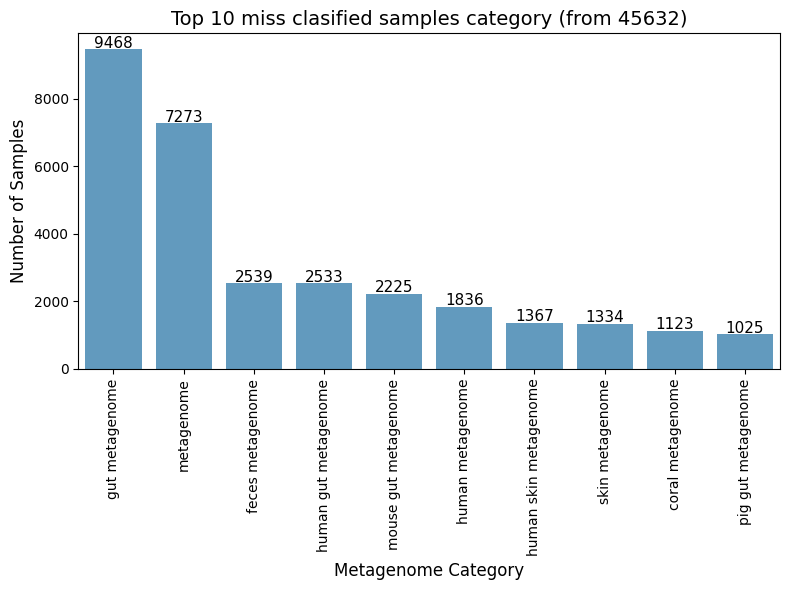

In [18]:
# Count the occurrences of each category
category_counts = df_misclassified["Scientific Name"].value_counts().head(10)

# Plot the histogram
plt.figure(figsize=(8, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, color=sns.color_palette("Blues_r")[2])
plt.xticks(rotation=90) 
# Labels and title
plt.xlabel("Metagenome Category", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.title(f"Top 10 miss clasified samples category (from {len(df_misclassified)})", fontsize=14)

# Show values on top of bars
for i, count in enumerate(category_counts.values):
    plt.text(i, count + 50, str(count), ha="center", fontsize=11 )
    
plt.tight_layout()
# Show the plot
plt.show()

# tree observation

In [2]:
from ete3 import Tree, TreeStyle, TextFace 
from IPython.display import display
import PIL.Image

In [46]:
# Load OTU Data
output_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/processed_otus_info.csv"
df_otus = pd.read_csv(output_path)

# Select N OTUs (Change method as needed: random, top by count, etc.)
N = 100  # Choose the number of OTUs
selected_otus = df_otus.sample(N)  # Random selection

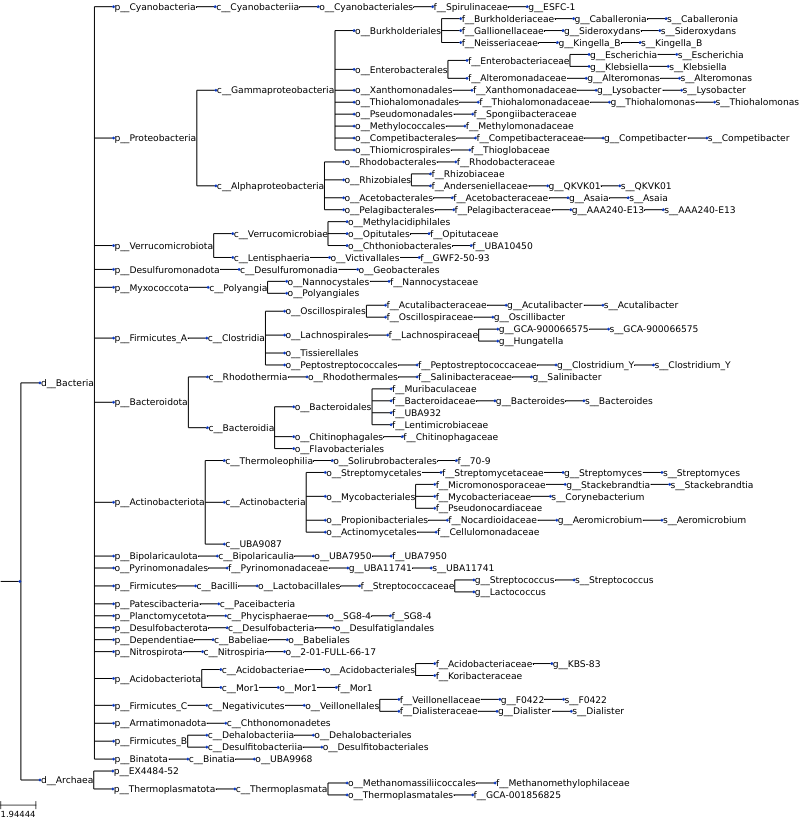

In [50]:
tree = Tree()

# Take unique tax strings (in your real code, you might do df["taxonomy"].dropna().unique())
unique_taxonomies = selected_otus["taxonomy"]

for tax_str in unique_taxonomies:
    # Split on ';' and strip
    levels = [lvl.strip() for lvl in tax_str.split(";") if lvl.strip()]

    # Start from root
    parent = tree
    
    for lvl in levels:
        # Search for an existing child with the same name
        match = None
        for child in parent.children:
            if child.name == lvl:
                match = child
                break

        # If found, descend; otherwise create a new child
        if match:
            parent = match
        else:
            parent = parent.add_child(name=lvl)

# OPTIONAL: Label each node with text
for node in tree.traverse():
    if not node.is_root():
        node.add_face(TextFace(node.name, fsize=10), column=0)

# Simple tree style (non‐circular)
ts = TreeStyle()
ts.show_leaf_name = False   # We already label with faces
ts.mode = "r"               # rectangular layout

# Render the tree
tree.render("taxonomy_tree.png", w=800, units="px", tree_style=ts)
display(PIL.Image.open("taxonomy_tree.png"))

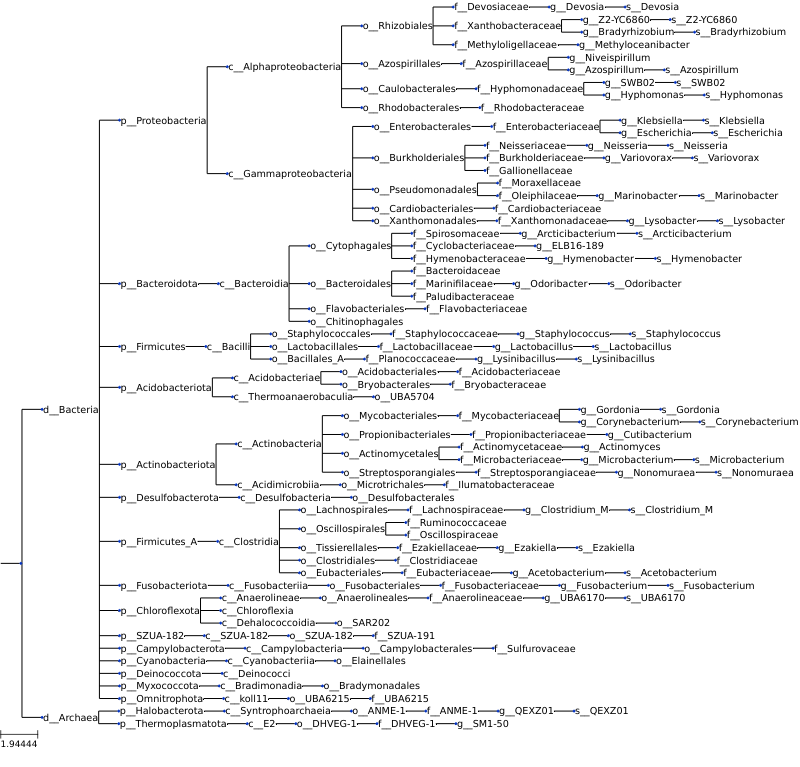


 Unique OTU Counts at Each Level:
s__Devosia: 1 OTUs
o__Enterobacterales: 1 OTUs
s__Arcticibacterium: 1 OTUs
s__Neisseria: 1 OTUs
p__Firmicutes: 1 OTUs
f__Bacteroidaceae: 1 OTUs
f__Acidobacteriaceae: 1 OTUs
s__Gordonia: 1 OTUs
s__Z2-YC6860: 1 OTUs
o__Bacteroidales: 1 OTUs
o__Desulfobacterales: 1 OTUs
f__Lachnospiraceae: 1 OTUs
o__Acidobacteriales: 1 OTUs
c__Bacteroidia: 1 OTUs
f__Ruminococcaceae: 1 OTUs
g__Niveispirillum: 1 OTUs
d__Bacteria: 1 OTUs
s__Staphylococcus: 1 OTUs
s__Ezakiella: 1 OTUs
s__Bradyrhizobium: 1 OTUs
s__Fusobacterium: 1 OTUs
f__Clostridiaceae: 1 OTUs
o__Microtrichales: 1 OTUs
s__UBA6170: 1 OTUs
c__Clostridia: 1 OTUs
f__SZUA-191: 1 OTUs
f__Sulfurovaceae: 1 OTUs
c__Chloroflexia: 1 OTUs
o__Elainellales: 1 OTUs
f__Flavobacteriaceae: 1 OTUs
s__SWB02: 1 OTUs
f__Moraxellaceae: 1 OTUs
f__Oscillospiraceae: 1 OTUs
g__Cutibacterium: 1 OTUs
s__Corynebacterium: 1 OTUs
g__Actinomyces: 1 OTUs
p__Acidobacteriota: 1 OTUs
s__Lactobacillus: 1 OTUs
c__Deinococci: 1 OTUs
f__Rhodobacter

In [72]:
from collections import defaultdict



# Load OTU Data
output_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/processed_otus_info.csv"
df_otus = pd.read_csv(output_path)

# Select N OTUs
N = 100  # Choose the number of OTUs
selected_otus = df_otus.sample(N, random_state=42)  # Random selection for reproducibility

tree = Tree()

# Unique taxonomies and a dictionary to store OTU counts at each level
unique_taxonomies = selected_otus["taxonomy"]
otu_counts = defaultdict(int)  # Store count of unique OTUs at each level

seen_otus = set()  # To ensure each OTU is counted only once at its deepest level

for tax_str in unique_taxonomies:
    levels = [lvl.strip() for lvl in tax_str.split(";") if lvl.strip()]  # Split & clean levels
    deepest_level = levels[-1]  # Get the deepest classification

    # Only count an OTU at its deepest level
    if deepest_level not in seen_otus:
        otu_counts[deepest_level] += 1
        seen_otus.add(deepest_level)

    # Build the tree structure
    parent = tree
    for lvl in levels:
        match = next((child for child in parent.children if child.name == lvl), None)
        parent = match if match else parent.add_child(name=lvl)

# OPTIONAL: Label each node with text
for node in tree.traverse():
    if not node.is_root():
        node.add_face(TextFace(node.name, fsize=10), column=0)

# Tree styling (rectangular)
ts = TreeStyle()
ts.show_leaf_name = False
ts.mode = "r"

# Render tree
tree.render("taxonomy_tree.png", w=800, units="px", tree_style=ts)
display(PIL.Image.open("taxonomy_tree.png"))

# Print OTU count summary per level
print("\n Unique OTU Counts at Each Level:")
for level, count in sorted(otu_counts.items(), key=lambda x: -x[1]):  # Sort descending
    print(f"{level}: {count} OTUs")

In [71]:
len(df_otus)

225066

# clasification per Taxonomi